# Working with the hourly Global Drifter Program (GDP) data

In this Notebook, we use the [hourly data](https://www.aoml.noaa.gov/phod/gdp/hourly_data.php) from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/global-drifter-program/) to illustrate the steps to preprocess a Lagrangian dataset into a `RaggedArray` format that can be then emitted as `xarray.Dataset` or `awkward.Array` instances.

## Import the `RaggedArray` class

In [1]:
from clouddrift import RaggedArray

The `RaggedArray` class can be initialized with a series of `dict`s matching the name of the variables of the original data with the ragged representation of the data and their respectives attributes.

In [2]:
help(RaggedArray)

Help on class RaggedArray in module clouddrift.raggedarray:

class RaggedArray(builtins.object)
 |  RaggedArray(coords: 'dict', metadata: 'dict', data: 'dict', attrs_global: 'dict | None' = {}, attrs_variables: 'dict | None' = {}, name_dims: 'dict[str, DimNames]' = {}, coord_dims: 'dict[str, str]' = {})
 |
 |  Methods defined here:
 |
 |  __init__(self, coords: 'dict', metadata: 'dict', data: 'dict', attrs_global: 'dict | None' = {}, attrs_variables: 'dict | None' = {}, name_dims: 'dict[str, DimNames]' = {}, coord_dims: 'dict[str, str]' = {})
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  to_awkward(self)
 |      Convert ragged array object to an Awkward Array.
 |
 |      Returns
 |      -------
 |      ak.Array
 |          Awkward Array containing the ragged array and its attributes
 |
 |  to_netcdf(self, filename: 'str')
 |      Export ragged array object to a NetCDF file.
 |
 |      Parameters
 |      ----------
 |      filename : str
 |          Name 

The length of the variables in the dataset is either equal to the number of trajectories (`nb_traj`) or the number of observations (`obs`) derived along the trajectories. 

The first three dictionnaries, `coords`, `metadata`, and `data`, match the variable names for coordinates variables, metatadata variables, and data variables, respectively, with the ragged representation of the data.

- The coordinates are mandatory variables (length `obs`) for the ragged array to be used with the library and are always `time`, `lon`, `lat`, and `ids`. 
- The metadata variables (length `nb_traj`) are constant values associated with a single trajectory such as the length of the observations (`rowsize`), the deployment information (`deploy_lon`, `deploy_lat`, `deploy_date`), the type of buoys (`typebuoy`), etc.
- The data variables (length `obs`) are quantity derived along the trajectories such as velocity component (`ve`, `vn`), the sea surface temperature and its uncertainty (`sst`, `err_sst`), the drogue presence flag (`drogue_status`), etc.

The last two dictionaries, `attrs_global` and `attrs_variables`, are optional and contain the attributes related to the dataset and each variable, respectively.

## The `RaggedArray.from_files()` method

This method is available to initialize a `RaggedArray` instance from a series of files.

In [3]:
help(RaggedArray.from_files)

Help on method from_files in module clouddrift.raggedarray:

from_files(indices: 'list[int]', preprocess_func: 'Callable[[int], xr.Dataset]', name_coords: 'list', name_meta: 'list' = [], name_data: 'list' = [], name_dims: 'dict[str, DimNames]' = {}, rowsize_func: 'Callable[[int], int] | None' = None, attrs_global: 'dict | None' = None, attrs_variables: 'dict | None' = None, **kwargs) class method of clouddrift.raggedarray.RaggedArray
    Generate a ragged array archive from a list of files

    Parameters
    ----------
    indices : list
        Identification numbers list to iterate
    preprocess_func : Callable[[int], xr.Dataset]
        Returns a processed xarray Dataset from an identification number
    name_meta : list, optional
        Name of metadata variables to include in the archive (Defaults to [])
    name_data : list, optional
        Name of the data variables to include in the archive (Defaults to [])
    name_dims: dict
        Map an alias to a dimension.
    rowsiz

This method was inspired by the [Pangeo Forge](https://pangeo-forge.readthedocs.io/en/latest/) project which aims at easing the extraction of data from traditional data archives and deposition in cloud object storage. For our `RaggedArray.from_files()` method, the different parameters are:

- `indices`: a list of indices (or identification numbers) that will be iterated over to concatenate the files into the `RaggedArray` instance;
- `preprocess_func`: A preprocessing function with the following signature:
    - `Signature: preprocess_func(index: int) -> xarray.core.dataset.Dataset`, where the index parameter is an identifier of a trajectory, e.g. the identification number of an Argo float) and returns an [xarray Dataset](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.html). 
- `vars_coords`: a dictionary mapping the mandatory coordinates list to the name of those variables in the dataset, e.g.
    `coords = {'ids': 'number', 'time': 't', 'lon': 'longitude', 'lat': 'latitude'}`
- `vars_meta`: an optional list of variable names containing metadata information about the trajectory (size: 1 per trajectory)
- `vars_data`: an optional list of variable names containing the data along the trajectory (size: number of observations per trajectory)
- `rowsize_func`: an optional function that returns directly the number of observation of a trajectory (`Signature: rowsize_func(index: int) -> int`)

Because every dataset is unique, the preprocessing function is used to perform operations such as: formatting the date and time, changing the type of the variables, modifying the metadata, and similar. The class also needs to initially calculate the sum of all observations to allocate memory. To speed up this process where a lot of preprocessing is needed, it is possible to provide a second function `rowsize_func`, that returns directly the number of observations of a trajectory (`Signature: rowsize_func(index: int) -> int`). By default, this operation is performed using `lambda i: preprocess_func(i).dims['obs']`. 

We provide preprocessing function for different datasets in the `data/` folder (`gdp.py`, `gdp6h.py`, `parcels.py`, etc.) and those can serve as a guide to defined a new set of functions for another dataset.

# Dataset-specific functions
The `gdp.py` (inside `clouddrift.adapters`) module contains  a number of specific functions for the current GDP files, including:
- `gdp.preprocess`: applies preprocessing routine and returned a `xarray.Dataset` for a specific trajectory 
- `gdp.download`: fetches NetCDF files from the GDP FTP server
- `gdp.rowsize [Optional]`: returns the dimension of a specific trajectory to speed up the preprocessing

In [4]:
from clouddrift.adapters import gdp1h

## Download the GDP data

The `gdp.download` function will store the raw dataset into the `data/raw/gdp-v2.00/` folder (specified in the `gdp.py` module). By default `download()` will download the complete GPD dataset (containing 17,324 files for versions 1.04c and 2.00) from the AOML repository ([link](https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/hourly/v2.00/netcdf/)).

In [5]:
help(gdp1h.download)

Help on function download in module clouddrift.adapters.gdp1h:

download(url: str = 'https://www.aoml.noaa.gov/ftp/pub/phod/buoydata/hourly_product/v2.01', tmp_path: str = '/var/folders/_6/hdhmyzr120jgn1d_45q65zkh0000gn/T/clouddrift/gdp', drifter_ids: list[int] | None = None, n_random_id: int | None = None)
    Download individual NetCDF files from the AOML server.

    Parameters
    ----------
    url : str
        URL from which to download the data.
    tmp_path : str
        Path to the directory where the individual NetCDF files are stored.

    drifter_ids : list, optional
        List of drifter to retrieve (Default: all)
    n_random_id : int, optional
        Randomly select n_random_id drifter IDs to download (Default: None)
    Returns
    -------
    out : list
        List of retrieved drifters



With this function, it is also possible to retrieve a subset from a `drifter_ids` list or specified an integer `n_random_id` to randomly retrieve `n` trajectories. If both arguments are given, the function downloads `n_random_id` out of the list `drifter_ids`. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [6]:
drifter_ids = gdp1h.download(n_random_id=100)

In [7]:
drifter_ids[:5]

array([9729740, 9721516,   18677,   30717,   34274])

## Create the `RaggedArray` instance

Once the data are downloaded, the *RaggedArray* object can be created and archived as a NetCDF file or a parquet file. In addition, the ragged array can be converted to an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or an [Awkward Array](https://awkward-array.readthedocs.io/en/stable/_auto/ak.Array.html) in order to conduct analyses.

Before we do that, we must first define the dataset-specific coordinates, data, and metadata information.

In [8]:
dimensions = {"traj": "rows", "obs": "obs"}

coords = [
    "id",
    "time",
]

metadata = [
    "ID",
    "rowsize",
    "WMO",
    "expno",
    "deploy_date",
    "deploy_lat",
    "deploy_lon",
    "end_date",
    "end_lat",
    "end_lon",
    "drogue_lost_date",
    "typedeath",
    "typebuoy",
    "location_type",
    "DeployingShip",
    "DeploymentStatus",
    "BuoyTypeManufacturer",
    "BuoyTypeSensorArray",
    "CurrentProgram",
    "PurchaserFunding",
    "SensorUpgrade",
    "Transmissions",
    "DeployingCountry",
    "DeploymentComments",
    "ManufactureYear",
    "ManufactureMonth",
    "ManufactureSensorType",
    "ManufactureVoltage",
    "FloatDiameter",
    "SubsfcFloatPresence",
    "DrogueType",
    "DrogueLength",
    "DrogueBallast",
    "DragAreaAboveDrogue",
    "DragAreaOfDrogue",
    "DragAreaRatio",
    "DrogueCenterDepth",
    "DrogueDetectSensor",
]
data = [
    "lon",
    "lon360",
    "lat",
    "ve",
    "vn",
    "err_lat",
    "err_lon",
    "err_ve",
    "err_vn",
    "gap",
    "sst",
    "sst1",
    "sst2",
    "err_sst",
    "err_sst1",
    "err_sst2",
    "flg_sst",
    "flg_sst1",
    "flg_sst2",
    "drogue_status",
]

In [9]:
# this is only required for the gdp preprocess function
gdp1h_custom_args = {
    "tmp_path": gdp1h.GDP_TMP_PATH,
    "filename_pattern": "drifter_hourly_{id}.nc",
}

ra = RaggedArray.from_files(
    drifter_ids,
    gdp1h.preprocess,
    coords,
    metadata,
    data,
    dimensions,
    **gdp1h_custom_args,
)

Retrieving the number of obs:   0%|                     | 0/100 [00:00<?, ?it/s]/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/adapters/gdp1h.py:513: UserWarning: Variable ManufactureYear not found in upstream data; skipping.
  warnings.warn(f"Variable {var} not found in upstream data; skipping.")
Retrieving the number of obs:  75%|█████████   | 75/100 [00:10<00:00, 27.89it/s]/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/adapters/gdp1h.py:202: RuntimeWarning: invalid value encountered in cast
  ds[var].data = ds[var].data.astype(target_dtype[var])
Retrieving the number of obs: 100%|███████████| 100/100 [00:11<00:00,  8.58it/s]
/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/raggedarray.py:407: UserWarning: Variable ID requested but not found; skipping.
  warnings.warn(f"Variable {var} requested but not found; skipping.")
/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/raggedarray.

# Direct construction of the ragged array
- `to_raggedarray()` performs automatically the steps shown above

In [10]:
ra = gdp1h.to_raggedarray(n_random_id=100)

Retrieving the number of obs: 100%|██████████| 100/100 [00:00<00:00, 153.01it/s]
/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/adapters/gdp1h.py:513: UserWarning: Variable ManufactureYear not found in upstream data; skipping.
  warnings.warn(f"Variable {var} not found in upstream data; skipping.")
/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/raggedarray.py:407: UserWarning: Variable ManufactureYear requested but not found; skipping.
  warnings.warn(f"Variable {var} requested but not found; skipping.")
Filling the Ragged Array:   0%|                         | 0/100 [00:00<?, ?it/s]/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/raggedarray.py:440: UserWarning: Variable ManufactureYear requested but not found; skipping.
  warnings.warn(
Filling the Ragged Array:  75%|████████████    | 75/100 [00:02<00:00, 29.26it/s]/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/clouddrift/adapters/gdp1h.py:

## Export to data files

Currently, the library supports exporting the `RaggedArray` instance to NetCDF and Apache Parquet file formats.

### NetCDF

In [11]:
ra.to_netcdf("../data/process/gdp_v2.00.nc")

### Apache Parquet

In [12]:
ra.to_parquet("../data/process/gdp_v2.00.parquet")

## Import from data files

As with exporting to files, we can import a `RaggedArray` instance from a NetCDF or Apache Parquet files. 

### NetCDF

In [13]:
ra = RaggedArray.from_netcdf(
    "../data/process/gdp_v2.00.nc", rows_dim_name="traj", obs_dim_name="obs"
)

### Apache Parquet

In [20]:
ra = RaggedArray.from_parquet(
    "../data/process/gdp_v2.00.parquet",
    name_coords=["id", "time"],
    name_dims={"traj": "rows", "obs": "obs"},
    coord_dims={"id": "traj", "time": "obs"},
)

KeyError: ('awkward_NumpyArray_pad_zero_to_length', <class 'numpy.uint8'>, <class 'numpy.int32'>, <class 'numpy.uint8'>)

## Converting to data structures for analysis

Typically, you would not do your data analysis directly on a `RaggedArray` instance.
Instead, you first convert it to a data structure that is geared for data analysis and exploratory science.
Currently, the library supports Xarray Dataset and Awkward Array structures.

### Xarray Dataset

In [21]:
ds = ra.to_xarray()

Now we have our GDP dataset as an Xarray Dataset while also being optimized for memory.
Let's see what's inside:

In [22]:
ds

<xarray.Dataset> Size: 93MB
Dimensions:                (traj: 100, obs: 1163829)
Coordinates:
    id                     (traj) int64 800B 9729740 9721516 ... 300234068703110
    time                   (obs) datetime64[ns] 9MB 1998-02-13T03:00:00 ... 2...
Dimensions without coordinates: traj, obs
Data variables: (12/58)
    rowsize                (traj) int32 400B 30276 9290 23600 ... 4254 969 3073
    WMO                    (traj) int32 400B 4600927 3300555 ... 2302575 6203650
    expno                  (traj) int32 400B 8556 243 9325 ... 21312 21312 2222
    deploy_date            (traj) datetime64[ns] 800B 1998-02-06 ... 2021-09-30
    deploy_lat             (traj) float32 400B 27.41 -50.02 -43.0 ... 8.04 54.4
    deploy_lon             (traj) float32 400B -144.1 -29.97 33.47 ... 69.46 4.0
    ...                     ...
    err_sst1               (obs) float32 5MB 0.385 0.375 0.364 ... nan nan nan
    err_sst2               (obs) float32 5MB 0.423 0.392 0.226 ... nan nan nan
    flg_sst                (obs) int8 1MB 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0
    flg_sst1               (obs) int8 1MB 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0
    flg_sst2               (obs) int8 1MB 4 4 4 4 2 4 4 4 4 ... 0 0 0 0 0 0 0 0
    drogue_status          (obs) bool 1MB True True True ... False False False
Attributes: (12/18)
    title:                Global Drifter Program hourly drifting buoy collection
    history:              version 2.01. Metadata from dirall.dat and deplog.dat
    Conventions:          CF-1.6
    time_coverage_start:  1998-02-13:03:00:00Z
    time_coverage_end:    2022-10-31:00:00:00Z
    date_created:         2024-06-11T23:10:06.880043
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centu...
    summary:              Global Drifter Program hourly data
    doi:                  10.25921/x46c-3620


Time, longitude, and latitude arrays are 1-dimensional and are effectively a concatenated list of drifter trajectories. The `ids` array, created by repeating the drifter `id` according to `rowsize`, can be used to mask (subset) a specific drifter. Let"s make a trajectory map by looping over all the trajectories and plotting them one by one.

In [26]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

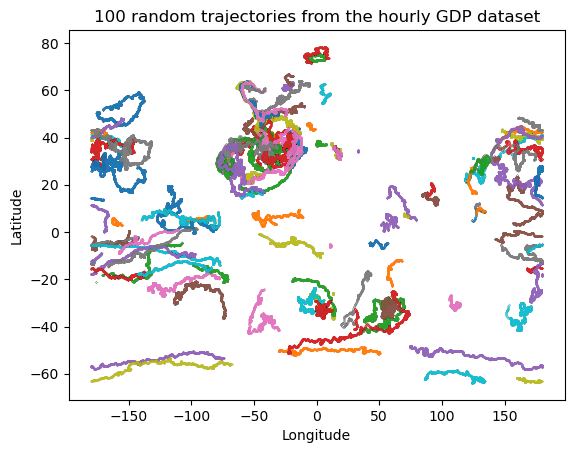

In [27]:
ids = np.repeat(ds.id, ds.rowsize).values

for drifter_id in drifter_ids:
    this_drifter = ids == drifter_id
    plt.plot(
        ds.lon[this_drifter], ds.lat[this_drifter], linestyle="", marker=".", ms=0.1
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the hourly GDP dataset")

You may find that the method above is relatively slow to plot for a large number of trajectories. Alternatively, we can use `rowsize_to_index` from the `clouddrift.ragged` module, which returns an array that indexes the beginning of each trajectory in the ragged arrays (with index `0` for the first trajectory).

In [28]:
from clouddrift.ragged import rowsize_to_index

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

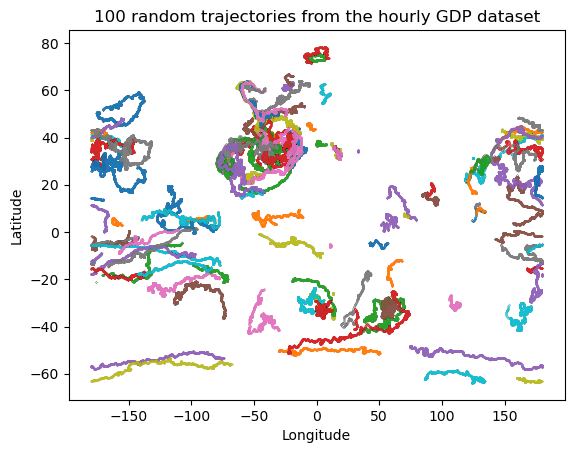

In [29]:
traj_idx = rowsize_to_index(ds.rowsize)

for j in range(len(drifter_ids)):
    plt.plot(
        ds.lon[slice(traj_idx[j], traj_idx[j + 1])],
        ds.lat[slice(traj_idx[j], traj_idx[j + 1])],
        linestyle="",
        marker=".",
        ms=0.1,
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the hourly GDP dataset")

### Awkward Array

In [30]:
ds = ra.to_awkward()

With an awkward array, there is no need to define an index variable as for an xarray Dataset:

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

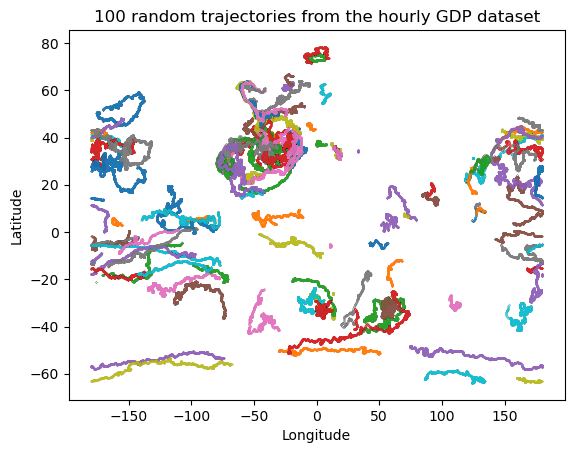

In [31]:
for n in range(len(drifter_ids)):
    plt.plot(ds.obs["lon"][n], ds.obs["lat"][n], linestyle="", marker=".", ms=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the hourly GDP dataset")